In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [26]:
# import merged data withou the index column
df = pd.read_csv('merged_df.csv', index_col=None)
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'finalResult',
       'academicGrade', 'absences_range'],
      dtype='object')

In [27]:
# Get the position of categorical columns
catColumnsPos = [df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df.select_dtypes('object').columns)))
# print('Categorical columns position  : {}'.format(catColumnsPos))
categorical_cols = df.select_dtypes(include=['object', 'category'])
numerical_cols = df.select_dtypes(include=['float64', 'int64'])

# remove bad columns 
categorical_cols = categorical_cols.drop(['absences_range', 'academicGrade'], axis=1)

Categorical columns           : ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'finalResult', 'academicGrade', 'absences_range']


In [28]:
# encode categorical columns with the method get_dummies,
# and left target and continuous columns.

categorical_cols = pd.get_dummies(df[df.columns[~df.columns.isin(['age', 
                                                                  'absences', 'absences_range', 'academicGrade'])]])

In [29]:
# Choose the continuous columns
numerical_cols = df[['age', 'absences']]

num_scaled = pd.concat([categorical_cols, numerical_cols], axis=1)
# normalize continous columns
scaler = MinMaxScaler()
df_final = pd.DataFrame(scaler.fit_transform(num_scaled), columns=num_scaled.columns)

# Add label column
df_final['finalResult'] = df['finalResult']


In [30]:
# tranform only label column from fail to pass in 0 and 1
df_final['finalResult'] = df_final['finalResult'].apply(lambda x: 0 if x == 'fail' else 1)

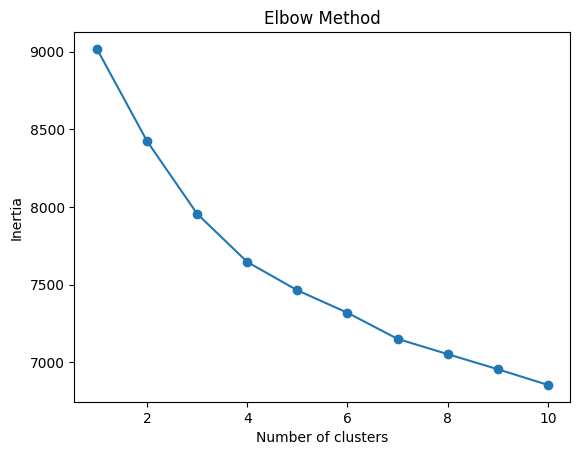

In [31]:
# Create a Kmeeans model with n clusters and fit tune the model
# to get the best number of clusters
def kmeans_model(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data)
    return kmeans.inertia_

# Create a list of inertia values for each number of clusters
inertia_values = []
for i in range(1, 11):
    inertia_values.append(kmeans_model(i, df_final))
    
# Plot the inertia values
plt.plot(range(1, 11), inertia_values, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.model_selection import GridSearchCV

# X is the data matrix
param_grid = {'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
kmeans = KMeans(init='k-means++', max_iter=300, n_init=10, random_state=0)
silhouette_scorer = make_scorer(silhouette_score)
grid_search = GridSearchCV(kmeans, param_grid=param_grid, scoring=silhouette_scorer)
# remove label column
df_final = df_final.drop(['finalResult'], axis=1)
grid_search.fit(df_final)
print("Best n_clusters:", grid_search.best_params_['n_clusters'])
print("Best silhouette score:", grid_search.best_score_)


Best n_clusters: 2
Best silhouette score: nan


In [35]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# X is the data matrix
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit(df_final)

In [36]:
# Predicting the Clusters
pd.options.display.max_columns = 10
predictions = y_kmeans.labels_
df_final['Clusters'] = predictions
df_final

,Medu,Fedu,traveltime,studytime,failures,...,finalResult_fail,finalResult_pass,age,absences,Clusters
0,1.00,1.00,0.333333,0.333333,0.000000,...,1.0,0.0,0.428571,0.080000,1
1,0.25,0.25,0.000000,0.333333,0.000000,...,1.0,0.0,0.285714,0.053333,1
2,0.25,0.25,0.000000,0.333333,1.000000,...,0.0,1.0,0.000000,0.133333,1
3,1.00,0.50,0.000000,0.666667,0.000000,...,0.0,1.0,0.000000,0.026667,1
4,0.75,0.75,0.000000,0.333333,0.000000,...,0.0,1.0,0.142857,0.053333,1
...,...,...,...,...,...,...,...,...,...,...,...
1039,0.50,0.75,0.000000,0.666667,0.333333,...,0.0,1.0,0.571429,0.053333,1
1040,0.75,0.25,0.000000,0.333333,0.000000,...,0.0,1.0,0.428571,0.053333,1
1041,0.25,0.25,0.333333,0.333333,0.000000,...,1.0,0.0,0.428571,0.080000,1
1042,0.75,0.25,0.333333,0.000000,0.000000,...,0.0,1.0,0.285714,0.080000,0
